In [62]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Считывание

In [4]:
path = kagglehub.dataset_download("willianoliveiragibin/uk-property-price-data-1995-2023-04")

100%|█████████████████████████████████████████████████████████████████████████████| 1.36G/1.36G [15:54<00:00, 1.53MB/s]

Extracting files...


In [5]:
print("Path to dataset files:", path)

Path to dataset files: C:\Users\Admin\.cache\kagglehub\datasets\willianoliveiragibin\uk-property-price-data-1995-2023-04\versions\1


In [23]:
data = pd.read_csv(path + '\\202304.csv')

In [38]:
data.columns=['transaction_unique_identifier', 'price', 'date_of_transfer','postcode', 'property_type', 'old_new',
'duration', 'paon', 'saon',
'street', 'locality', 'town_city',
'district', 'county', 'ppd_category_type',
'record_status'
]

In [56]:
data.head(10)

,transaction_unique_identifier,price,date_of_transfer,postcode,property_type,old_new,duration,paon,saon,street,locality,town_city,district,county,ppd_category_type,record_status,hour
15,{E104A9E7-1D6A-4D7F-B24F-5A064FCE6917},36500,1995-06-09,FY4 1DL,NaN,NaN,NaN,NaN,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
36,{748F870E-C337-4015-B5A3-4F499C6DDB0E},74000,1995-01-12,RH2 9NF,NaN,NaN,NaN,"SOMERS PLACE, 83 - 85",FLAT 21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
41,{A684561B-E2E7-4DF3-9E77-52EB66FBBB2A},13000,1995-04-07,CT9 1XR,NaN,NaN,NaN,NaN,FLAT 7A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
48,{3DAA73FB-713D-44EA-A500-4F49B450F4F1},29950,1995-03-31,BH1 4BD,NaN,NaN,NaN,"BROOKLYN COURT, 476",FLAT 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
72,{BA12EE6C-B9E2-43ED-9F74-4F4A6CFF79A3},26500,1995-12-11,BS23 3DT,NaN,NaN,NaN,"ASHCOMBE COURT, 43",FLAT 8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
92,{E3E7A54C-E2B1-4FE7-9C32-52EC36168C77},52000,1995-07-03,SE8 5AN,NaN,NaN,NaN,NaN,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
104,{568DE11A-432B-4DA3-B9A4-83B4EC4BD127},121250,1995-05-19,N12 8LR,NaN,NaN,NaN,NaN,FLAT 20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
114,{60CF8CE4-7269-4F41-9062-91F4932AC4A2},110995,1995-11-09,SW8 2PH,NaN,NaN,NaN,10,41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
115,{C03038E8-1504-4249-BDF9-91F4A24C8E35},34000,1995-08-18,FY5 4HW,NaN,NaN,NaN,NaN,FLAT 8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
130,{2D95D765-C921-4660-A97C-87383B7F9C88},39000,1995-05-19,BN16 2TJ,NaN,NaN,NaN,NaN,FLAT 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


# Процессинг

In [41]:
# Удаляем пустые строки и дубли
data = data.dropna().drop_duplicates()

In [42]:
# Преобразуем строки, не содержащие цифры, в пустые
data = data.applymap(lambda x: x if isinstance(x, (int, float)) or any(c.isdigit() for c in str(x)) else np.nan)

In [40]:
# Удаляем записи между 1 и 3 часами ночи (предполагаем, что есть столбец 'datetime')
if 'date_of_transfer' in data.columns:
    data['date_of_transfer'] = pd.to_datetime(data['date_of_transfer'])
    data = data[~((data['date_of_transfer'].dt.hour >= 1) & (data['date_of_transfer'].dt.hour <= 3))]

In [ ]:
data.head(10)

# Расчет метрик

In [46]:
# Расчет метрик по часам
aggregated_data = (
    data
    .groupby(data['date_of_transfer'].dt.hour)
    .agg(
        unique_strings=('transaction_unique_identifier', 'nunique'),  # Количество уникальных значений в string_col
        mean_numeric=('price', 'mean'),      # Среднее значение в numeric_col
        median_numeric=('price', 'median')   # Медиана в numeric_col
    )
    .reset_index()
    .rename(columns={'date_of_transfer': 'hour'})
)

-- SQL запрос для агрегации по часам
SELECT 
    EXTRACT(HOUR FROM date_of_transfer) AS hour,            -- Извлекаем час из столбца date_of_transfer
    COUNT(DISTINCT transaction_unique_identifier) AS unique_strings,   -- Количество уникальных значений в transaction_unique_identifier
    AVG(price) AS mean_numeric,               -- Среднее значение numeric_col
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY price) AS median_numeric  -- Медиана
FROM 
    table_name
GROUP BY 
    EXTRACT(HOUR FROM date_of_transfer)
ORDER BY 
    hour;

In [ ]:
data.head(10)

# Мерж с метриками

In [57]:
# Добавляем час в исходный датафрейм для мержинга
data['hour'] = data['date_of_transfer'].dt.hour

In [58]:
# Мержим данные с метриками по часам с исходным датафреймом
data = data.merge(aggregated_data, on='hour', how='left')

In [59]:
# Удаляем временный столбец 'hour' после мержинга
data = data.drop(columns='hour')

In [64]:
data.head(10)

,transaction_unique_identifier,price,date_of_transfer,postcode,property_type,old_new,duration,paon,saon,street,locality,town_city,district,county,ppd_category_type,record_status,unique_strings,mean_numeric,median_numeric
0,{E104A9E7-1D6A-4D7F-B24F-5A064FCE6917},36500,1995-06-09,FY4 1DL,NaN,NaN,NaN,NaN,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1552361,186431.351555,140000.0
1,{748F870E-C337-4015-B5A3-4F499C6DDB0E},74000,1995-01-12,RH2 9NF,NaN,NaN,NaN,"SOMERS PLACE, 83 - 85",FLAT 21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1552361,186431.351555,140000.0
2,{A684561B-E2E7-4DF3-9E77-52EB66FBBB2A},13000,1995-04-07,CT9 1XR,NaN,NaN,NaN,NaN,FLAT 7A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1552361,186431.351555,140000.0
3,{3DAA73FB-713D-44EA-A500-4F49B450F4F1},29950,1995-03-31,BH1 4BD,NaN,NaN,NaN,"BROOKLYN COURT, 476",FLAT 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1552361,186431.351555,140000.0
4,{BA12EE6C-B9E2-43ED-9F74-4F4A6CFF79A3},26500,1995-12-11,BS23 3DT,NaN,NaN,NaN,"ASHCOMBE COURT, 43",FLAT 8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1552361,186431.351555,140000.0
5,{E3E7A54C-E2B1-4FE7-9C32-52EC36168C77},52000,1995-07-03,SE8 5AN,NaN,NaN,NaN,NaN,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1552361,186431.351555,140000.0
6,{568DE11A-432B-4DA3-B9A4-83B4EC4BD127},121250,1995-05-19,N12 8LR,NaN,NaN,NaN,NaN,FLAT 20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1552361,186431.351555,140000.0
7,{60CF8CE4-7269-4F41-9062-91F4932AC4A2},110995,1995-11-09,SW8 2PH,NaN,NaN,NaN,10,41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1552361,186431.351555,140000.0
8,{C03038E8-1504-4249-BDF9-91F4A24C8E35},34000,1995-08-18,FY5 4HW,NaN,NaN,NaN,NaN,FLAT 8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1552361,186431.351555,140000.0
9,{2D95D765-C921-4660-A97C-87383B7F9C88},39000,1995-05-19,BN16 2TJ,NaN,NaN,NaN,NaN,FLAT 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1552361,186431.351555,140000.0


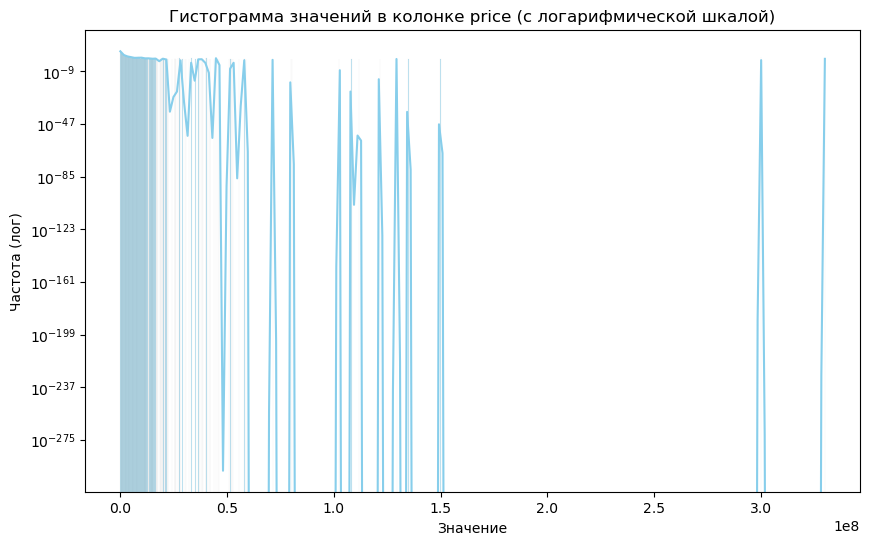

In [75]:
# Построение гистограммы
plt.figure(figsize=(10, 6))
sns.histplot(filtered_data['price'], bins=3000, kde=True, color='skyblue')

# Устанавливаем логарифмическую шкалу по оси y чтобы избежать"выброса"
plt.yscale('log')

plt.title('Гистограмма значений в колонке price (с логарифмической шкалой)')
plt.xlabel('Значение')
plt.ylabel('Частота (лог)')

plt.show()

In [77]:
#Расчет 95%-го доверительного интервала
from scipy import stats

mean = data['price'].mean()
std_dev = data['price'].std()
n = len(data['price'])

# Критическое значение для 95% доверительного интервала
z_score = stats.norm.ppf(0.975)

# Расчет интервала
ci_lower = mean - z_score * (std_dev / np.sqrt(n))
ci_upper = mean + z_score * (std_dev / np.sqrt(n))

print(f"95%-ный доверительный интервал: ({ci_lower:.2f}, {ci_upper:.2f})")

95%-ный доверительный интервал: (185039.93, 187822.78)


Использовальзовался метод на основе центральной предельной теоремы, поскольку он подходит для больших выборок, даже если данные имеют отклонение от нормального распределения. Эта теорема утверждает, что при большом объеме выборки распределение выборочного среднего будет близко к нормальному, что позволяет использовать критическое значение 𝑧 для нормального распределения.

# Визуализация

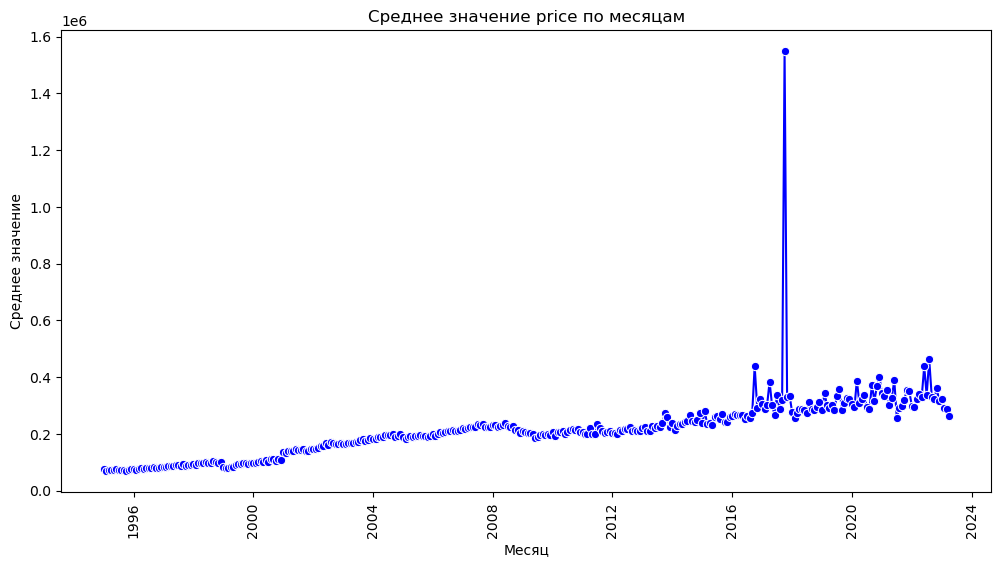

In [80]:
# График среднего значения price по месяцам

# Добавляем столбец месяца в исходный датафрейм
data['month'] = data['date_of_transfer'].dt.to_period('M')

# Рассчитываем среднее значение по месяцам
monthly_mean = data.groupby('month')['price'].mean().reset_index()

# Преобразуем month обратно в datetime для удобного отображения на графике
monthly_mean['month'] = monthly_mean['month'].dt.to_timestamp()

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_mean, x='month', y='price', marker='o', color='b')
plt.title('Среднее значение price по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Среднее значение')
plt.xticks(rotation=45)
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_19660\3280141706.py:13: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(x='character', y='count', data=char_df, jitter=True, palette='Blues_d')


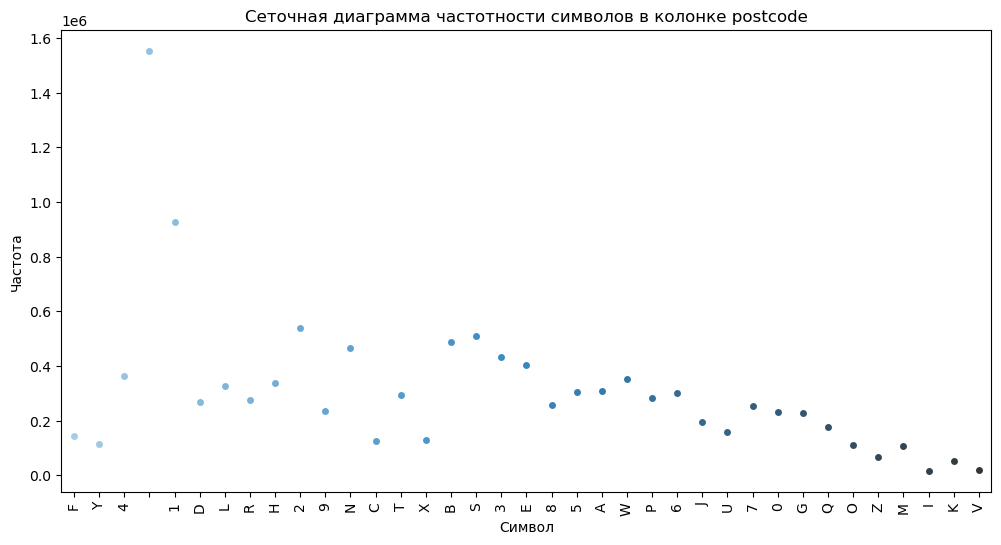

In [94]:
from collections import Counter

# Объединяем все строки в колонке postcode в один текст и считаем частотность каждого символа
all_chars = ''.join(data['postcode'].astype(str))
char_counts = Counter(all_chars)

# Преобразуем результаты в DataFrame
char_df = pd.DataFrame.from_dict(char_counts, orient='index', columns=['count']).reset_index()
char_df.columns = ['character', 'count']

# Строим диаграмму
plt.figure(figsize=(12, 6))
sns.stripplot(x='character', y='count', data=char_df, jitter=True, palette='Blues_d')
plt.title("Сеточная диаграмма частотности символов в колонке postcode")
plt.xlabel("Символ")
plt.ylabel("Частота")
plt.xticks(rotation=90)
plt.show()


# Доп. задание

In [95]:
# 1. Разделение датасета: Для случайного деления использована 
# функция train_test_split из sklearn, которая позволяет легко 
# разделить данные в пропорциях 25%, 25% и 50%.

from sklearn.model_selection import train_test_split

# Разделяем датасет на три части
data_25, temp_data = train_test_split(data, test_size=0.75, random_state=42)
data_25, data_50 = train_test_split(temp_data, test_size=0.666, random_state=42)

# Проверим размеры
print(len(data_25), len(data_50))


388866 775405


In [98]:
# 2. Проверка на статистическую значимость различий для среднего по колонке price
from scipy import stats

# t-тест для сравнения среднего значения price между двумя группами
t_stat, p_value = stats.ttest_ind(data_25['price'], data_50['price'])
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: 2.406513520917613, P-value: 0.016105762571669943


In [101]:
# 3. Оценка силы эффекта с использованием величины эффекта Кохен

from statsmodels.stats import weightstats as stests

# Расчет величины эффекта (Cohen's d)
mean_25 = np.mean(data_25['price'])
mean_50 = np.mean(data_50['price'])
std_25 = np.std(data_25['price'], ddof=1)
std_50 = np.std(data_50['price'], ddof=1)

cohen_d = (mean_25 - mean_50) / np.sqrt((std_25**2 + std_50**2) / 2)
print(f"Cohen's d: {cohen_d}")


Cohen's d: 0.004271501970526656


In [107]:
import numpy as np
import scipy.stats as stats

# Предположим, что data_25['price'] содержит наши данные
data = data_25['price'].values

# Инициализируем параметры (гиперпараметры для априорных распределений)
mu_prior_mean = 0
mu_prior_sd = 10
sigma_prior_sd = 10

# Количество выборок (например, 1000 для аппроксимации постериорного распределения)
n_samples = 1000

# Создадим пустые массивы для выборки
mu_samples = np.zeros(n_samples)
sigma_samples = np.zeros(n_samples)

# Оценка через метод MCMC
for i in range(n_samples):
    # Образцы из априорного распределения для mu и sigma
    mu_sample = np.random.normal(mu_prior_mean, mu_prior_sd)
    sigma_sample = np.abs(np.random.normal(0, sigma_prior_sd))  # Используем абсолютное значение для полунормального распределения

    # Вероятностная оценка данных (подсчёт правдоподобия)
    likelihood = np.sum(stats.norm.logpdf(data, loc=mu_sample, scale=sigma_sample))
    
    # Храним результаты выборки
    mu_samples[i] = mu_sample
    sigma_samples[i] = sigma_sample

# Оценка среднего значения для mu
mu_mean = np.mean(mu_samples)
sigma_mean = np.mean(sigma_samples)

print(f"Оценка среднего значения для mu: {mu_mean}")
print(f"Оценка средней величины для sigma: {sigma_mean}")



Оценка среднего значения для mu: 0.07511676841174901
Оценка средней величины для sigma: 7.884153841616924


## Доп задание 2

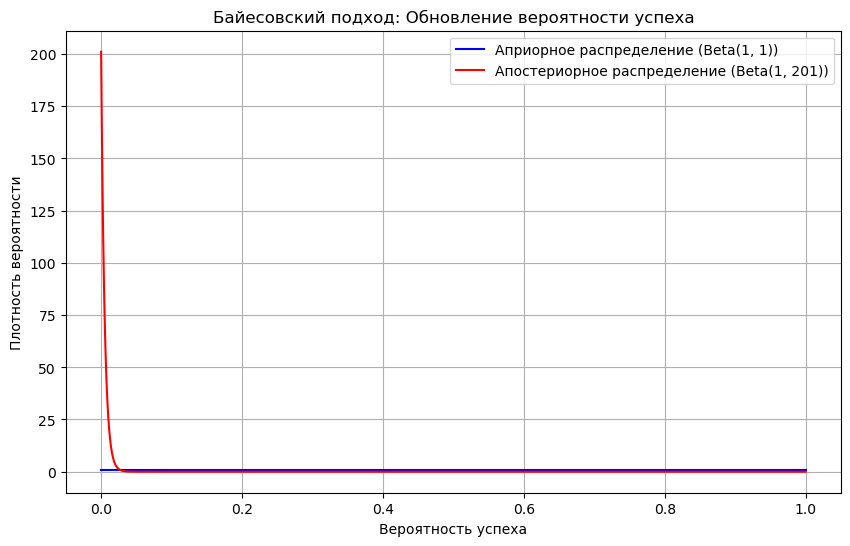

Ожидаемая вероятность успеха 201-го прототипа: 0.0050


In [109]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

# Данные
successful_competitor = 5  # успешные игры конкурента
total_competitor = 1000  # всего игр у конкурента
successful_ours = 0  # успешные игры нашей компании
total_ours = 200  # всего игр у нашей компании

# Априорное распределение (Бета распределение с параметрами 1, 1 - равномерное)
alpha_prior = 1
beta_prior = 1

# Обновление параметров Бета распределения на основе данных
alpha_post = alpha_prior + successful_ours  # успешные игры у нас
beta_post = beta_prior + (total_ours - successful_ours)  # неуспешные игры у нас

# Создаём значения для вероятности успеха
x = np.linspace(0, 1, 1000)

# Априорная и апостериорная плотности
prior_pdf = beta.pdf(x, alpha_prior, beta_prior)
posterior_pdf = beta.pdf(x, alpha_post, beta_post)

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(x, prior_pdf, label='Априорное распределение (Beta(1, 1))', color='blue')
plt.plot(x, posterior_pdf, label=f'Апостериорное распределение (Beta({alpha_post}, {beta_post}))', color='red')
plt.title("Байесовский подход: Обновление вероятности успеха")
plt.xlabel("Вероятность успеха")
plt.ylabel("Плотность вероятности")
plt.legend()
plt.grid(True)
plt.show()

# Вероятность успеха для следующего прототипа (среднее апостериорного распределения)
expected_success_prob = alpha_post / (alpha_post + beta_post)
print(f"Ожидаемая вероятность успеха 201-го прототипа: {expected_success_prob:.4f}")



# Комментарий к тесту